Processing subject OAS30033, session d0133 with various frac values


Processing volumes for subject OAS30033 with frac=0.1: 100%|██████████| 164/164 [14:14<00:00,  5.21s/it]
Processing volumes for subject OAS30033 with frac=0.2: 100%|██████████| 164/164 [14:10<00:00,  5.19s/it]
Processing volumes for subject OAS30033 with frac=0.3: 100%|██████████| 164/164 [14:02<00:00,  5.13s/it]
Processing volumes for subject OAS30033 with frac=0.4: 100%|██████████| 164/164 [14:01<00:00,  5.13s/it]
Processing volumes for subject OAS30033 with frac=0.5: 100%|██████████| 164/164 [13:57<00:00,  5.11s/it]
Processing volumes for subject OAS30033 with frac=0.6: 100%|██████████| 164/164 [14:01<00:00,  5.13s/it]
Processing volumes for subject OAS30033 with frac=0.7: 100%|██████████| 164/164 [13:52<00:00,  5.08s/it]
Processing volumes for subject OAS30033 with frac=0.8: 100%|██████████| 164/164 [14:39<00:00,  5.36s/it]
Processing volumes for subject OAS30033 with frac=0.9: 100%|██████████| 164/164 [15:54<00:00,  5.82s/it]
Processing volumes for subject OAS30033 with frac=1.0: 

File /home/minyoungxi/MINYOUNGXI/XFL/Data/OASIS_MNI_to_TRs/sub-OAS30033_ses-d0133/bet_volume_frac_0.1_0.nii.gz not found, skipping...
File /home/minyoungxi/MINYOUNGXI/XFL/Data/OASIS_MNI_to_TRs/sub-OAS30033_ses-d0133/bet_volume_frac_0.2_0.nii.gz not found, skipping...
File /home/minyoungxi/MINYOUNGXI/XFL/Data/OASIS_MNI_to_TRs/sub-OAS30033_ses-d0133/bet_volume_frac_0.3_0.nii.gz not found, skipping...
File /home/minyoungxi/MINYOUNGXI/XFL/Data/OASIS_MNI_to_TRs/sub-OAS30033_ses-d0133/bet_volume_frac_0.4_0.nii.gz not found, skipping...
File /home/minyoungxi/MINYOUNGXI/XFL/Data/OASIS_MNI_to_TRs/sub-OAS30033_ses-d0133/bet_volume_frac_0.5_0.nii.gz not found, skipping...
File /home/minyoungxi/MINYOUNGXI/XFL/Data/OASIS_MNI_to_TRs/sub-OAS30033_ses-d0133/bet_volume_frac_0.6_0.nii.gz not found, skipping...
File /home/minyoungxi/MINYOUNGXI/XFL/Data/OASIS_MNI_to_TRs/sub-OAS30033_ses-d0133/bet_volume_frac_0.7_0.nii.gz not found, skipping...
File /home/minyoungxi/MINYOUNGXI/XFL/Data/OASIS_MNI_to_TRs/sub

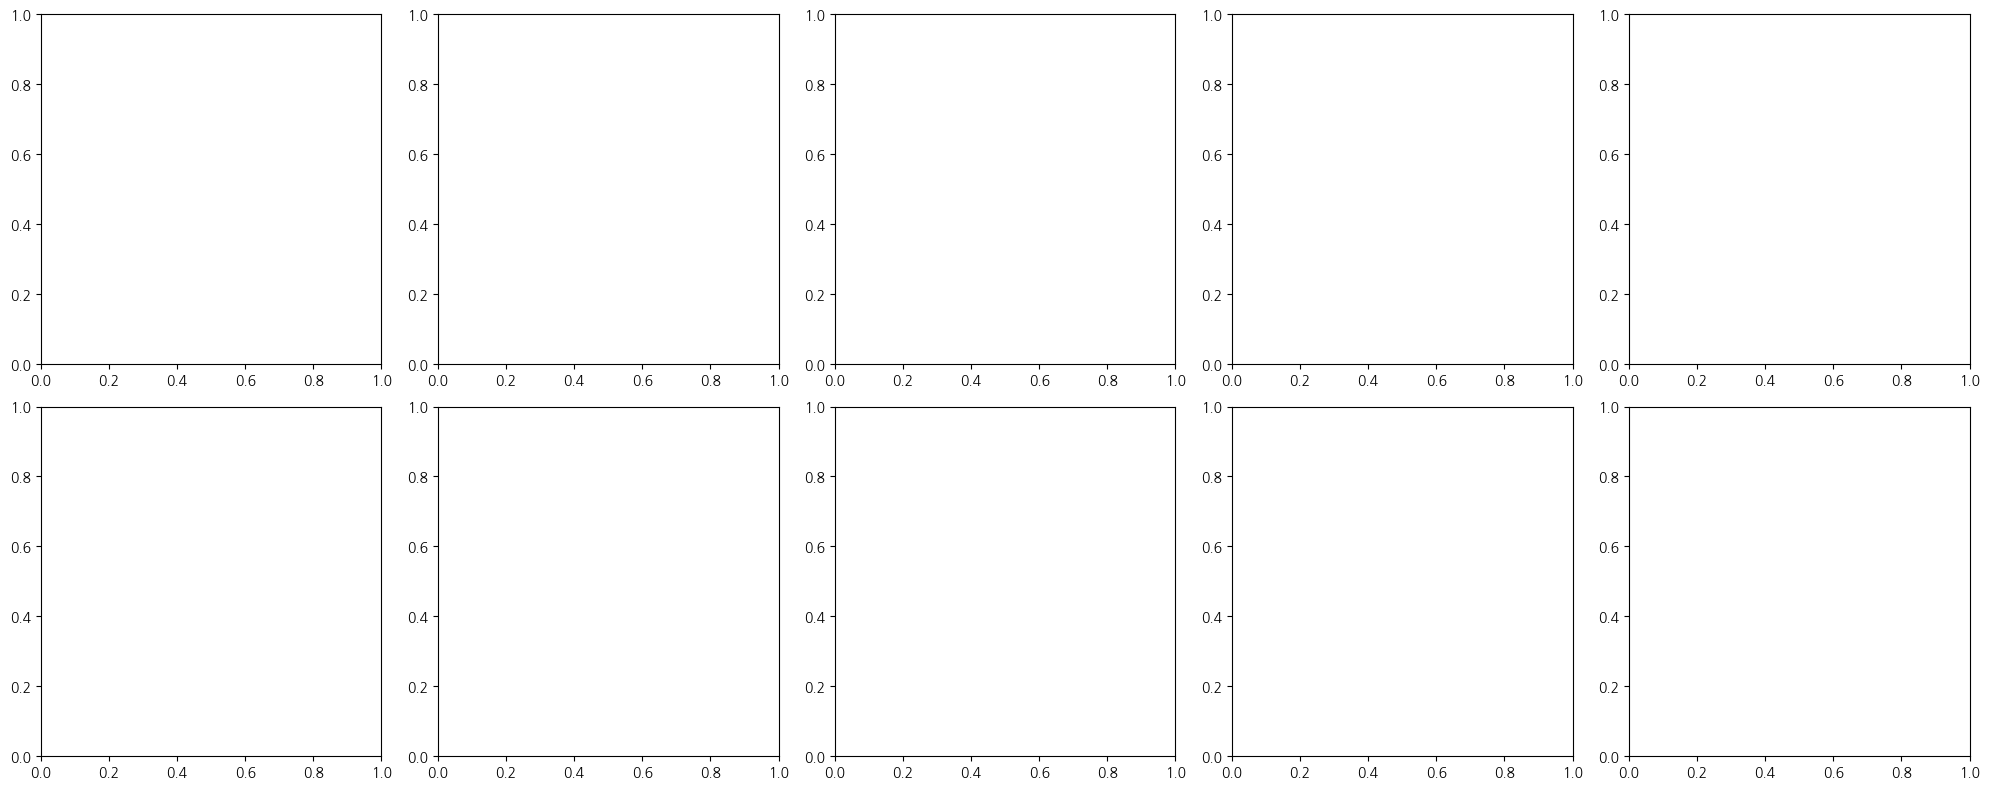

Preprocessing with various frac values completed.


In [9]:
import os
import nibabel as nib
import numpy as np
import torch
from nipype.interfaces import fsl
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

def run_bet(in_file, out_file, frac):
    bet = fsl.BET(in_file=in_file, out_file=out_file, frac=frac)
    result = bet.run()
    if not os.path.exists(out_file):
        print(f"Error: BET failed to create {out_file}")
    return result

def run_flirt(in_file, ref_file, out_file, out_matrix_file, dof=12):
    flirt = fsl.FLIRT()
    flirt.inputs.in_file = in_file
    flirt.inputs.reference = ref_file
    flirt.inputs.out_file = out_file
    flirt.inputs.out_matrix_file = out_matrix_file
    flirt.inputs.dof = dof
    flirt.inputs.cost = 'corratio'
    result = flirt.run()
    if not os.path.exists(out_file):
        print(f"Error: FLIRT failed to create {out_file}")
    return result

def preprocess_fmri_with_various_frac(func_file, standard_file, output_dir, subject_id, session_id):
    os.makedirs(output_dir, exist_ok=True)

    func_img = nib.load(func_file)
    func_data = func_img.get_fdata()
    num_volumes = func_data.shape[3]

    frac_values = np.arange(0.1, 1.1, 0.1)
    subject_output_dir = os.path.join(output_dir, f"sub-{subject_id}_ses-{session_id}")
    os.makedirs(subject_output_dir, exist_ok=True)

    for frac in frac_values:
        volume = func_data[:, :, :, 0]
        volume_img = nib.Nifti1Image(volume, func_img.affine)
        volume_file = os.path.join(output_dir, f"volume_frac_{frac:.1f}_0.nii.gz")
        nib.save(volume_img, volume_file)

        bet_output = os.path.join(subject_output_dir, f"bet_volume_frac_{frac:.1f}_0.nii.gz")
        run_bet(volume_file, bet_output, frac)

        if not os.path.exists(bet_output):
            continue

        mni_output = os.path.join(subject_output_dir, f"mni_volume_frac_{frac:.1f}_0.nii.gz")
        mni_matrix = os.path.join(subject_output_dir, f"mni_matrix_frac_{frac:.1f}_0.mat")
        run_flirt(bet_output, standard_file, mni_output, mni_matrix, dof=12)

        if not os.path.exists(mni_output):
            continue

        mni_volume = nib.load(mni_output).get_fdata()
        mni_volume_norm = (mni_volume - np.mean(mni_volume)) / np.std(mni_volume)

        # 첫 번째 타임포인트의 결과를 나머지 타임포인트에도 적용
        for i in tqdm(range(num_volumes), desc=f"Processing volumes for subject {subject_id} with frac={frac:.1f}"):
            volume = func_data[:, :, :, i]
            volume_img = nib.Nifti1Image(volume, func_img.affine)
            volume_file = os.path.join(output_dir, f"volume_frac_{frac:.1f}_{i}.nii.gz")
            nib.save(volume_img, volume_file)

            bet_output = os.path.join(subject_output_dir, f"bet_volume_frac_{frac:.1f}_{i}.nii.gz")
            run_bet(volume_file, bet_output, frac)

            if not os.path.exists(bet_output):
                continue

            mni_output = os.path.join(subject_output_dir, f"mni_volume_frac_{frac:.1f}_{i}.nii.gz")
            mni_matrix = os.path.join(subject_output_dir, f"mni_matrix_frac_{frac:.1f}_{i}.mat")
            run_flirt(bet_output, standard_file, mni_output, mni_matrix, dof=12)

            if not os.path.exists(mni_output):
                continue

            mni_volume = nib.load(mni_output).get_fdata()
            mni_volume_norm = (mni_volume - np.mean(mni_volume)) / np.std(mni_volume)

            torch.save(torch.from_numpy(mni_volume_norm).float(),
                       os.path.join(subject_output_dir, f"frame_frac_{frac:.1f}_{i:04d}.pt"))


            for file in [volume_file, bet_output, mni_output, mni_matrix]:
                if os.path.exists(file):
                    os.remove(file)

def visualize_bet_results(output_dir, subject_id, session_id):
    frac_values = np.arange(0.1, 1.1, 0.1)
    subject_output_dir = os.path.join(output_dir, f"sub-{subject_id}_ses-{session_id}")

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for i, frac in enumerate(frac_values):
        file_path = os.path.join(subject_output_dir, f"bet_volume_frac_{frac:.1f}_0.nii.gz")
        if not os.path.exists(file_path):
            print(f"File {file_path} not found, skipping...")
            continue

        img = nib.load(file_path)
        data = img.get_fdata()
        mid_slice = data[:, :, data.shape[2] // 2]

        ax = axes[i]
        ax.imshow(mid_slice.T, cmap='gray', origin='lower')
        ax.set_title(f'frac={frac:.1f}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def process_single_subject_with_various_frac(base_dir, output_dir, standard_file, subject_folder):
    subject_id = subject_folder.split('_')[0]
    session_id = subject_folder.split('_')[2]
    
    func_file = os.path.join(base_dir, subject_folder, "func2", "NIFTI", f"sub-{subject_id}_ses-{session_id}_task-rest_run-02_bold.nii.gz")
    
    if os.path.exists(func_file):
        print(f"Processing subject {subject_id}, session {session_id} with various frac values")
        preprocess_fmri_with_various_frac(func_file, standard_file, output_dir, subject_id, session_id)
        visualize_bet_results(output_dir, subject_id, session_id)

base_dir = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1"
output_dir = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASIS_MNI_to_TRs"
standard_file = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz')

sample_subject_folder = os.listdir(base_dir)[0]
process_single_subject_with_various_frac(base_dir, output_dir, standard_file, sample_subject_folder)

print("Preprocessing with various frac values completed.")
